In [2]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay
from multipy.fwer import sidak, hochberg
import random
import logomaker

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_clonotype_clustering_with_epitope_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, split_data, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                    create_summary_stats_table
from utils.weblogo_utils import create_web_logo

from source.tests_analysis.significant_clonotype_matrix_creation import create_significant_clonotype_matrix

import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.ml_utils")
importlib.reload(imported_module)

<module 'utils.ml_utils' from '/home/evlasova/tcr-covid-classifier/utils/ml_utils.py'>

In [3]:
pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_random_488.csv')
pvals = pvals[pvals.pval < 0.0005]
pvals

,Unnamed: 0,clone,pval
1378,1378,CAGRDRGTEAFF,0.000247
2386,2386,CAGSQNYGYTF,0.000457
2439,2439,CAGSRGSTEAFF,0.000170
8567,8567,CAISERGGTEAFF,0.000395
8721,8721,CAISERSYNEQFF,0.000130
...,...,...,...
924882,924882,CSVRVDYGYTF,0.000130
926571,926571,CSVVQGANTEAFF,0.000472
927295,927295,CTSSLGRGSNQPQHF,0.000170
928164,928164,GASSPGSSGANVLTF,0.000176


In [4]:
pvals[['clone']].to_csv('data/covid_significant_clones_fmba_TRB_random_488.csv', index=False)

In [5]:
create_significant_clonotype_matrix(clonotype_matrix_path='data/clone_matrix_fmba_TRB_top_500k.csv', 
                                    significant_clones_path='data/covid_significant_clones_fmba_TRB_random_488.csv', 
                                    save_path='data/significant_clone_matrix_fisher_fmba_TRB_random_488.csv')

In [6]:
random.seed(42)
selected_runs = random.sample(set(prepare_run_column(pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv')).run), 488)

In [7]:
data_random_TRB = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_random_488.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     selected_runs=selected_runs)

In [8]:
data_random_TRA = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_random_488.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     selected_runs=selected_runs)

In [9]:
X_train_rb, y_train_rb, X_test_rb, y_test_rb = split_data(data=data_random_TRB, y_column='covid', by='is_test_run')
best_clfs_rb = evaluate_models(X_train_rb, y_train_rb, X_test_rb, y_test_rb, 
                              get_parameters(), scoring_function='f1_weighted', debug=False)

classifier       svm        ab       knn      rfc  mlpclassifier  xgboost
f1-score    0.745763  0.666667  0.076923  0.60241       0.741935      0.6
Best model is svm with params: {'model__C': 5, 'model__kernel': 'rbf', 'model__probability': True, 'model__random_state': 42}


In [10]:
X_train_ra, y_train_ra, X_test_ra, y_test_ra = split_data(data=data_random_TRA, y_column='covid', by='is_test_run')
best_clfs_ra = evaluate_models(X_train_ra, y_train_ra, X_test_ra, y_test_ra, 
                              get_parameters(), scoring_function='f1_weighted', debug=False)

classifier       svm        ab       knn       rfc  mlpclassifier   xgboost
f1-score    0.610169  0.538462  0.633333  0.630137       0.641509  0.634921
Best model is mlpclassifier with params: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (150, 100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}


In [11]:
a02_runs = prepare_run_column(pd.read_csv('data/hla_desc/fmba_desc_hla_A*02.csv')).run

In [43]:
data_ab = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRB_A02.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=True, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     selected_runs=a02_runs)

In [41]:
data_aa = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv',
                     desc_path='data/standardized_usage_matrix_fmba_TRA.csv',
                     clonotype_matrix_path='data/significant_clone_matrix_fisher_fmba_TRA_A02.csv',
                     hla_keys_path='data/hla_keys.csv',
                     make_freq=True, 
                     use_hla_clones=False, 
                     use_hla_bool=False, 
                     make_all_features_bool=False, 
                     use_standardization=True,
                     raw_target_column='covid',
                     raw_target_clumn_success_label='covid',
                     selected_runs=a02_runs)

In [45]:
X_train_ab, y_train_ab, X_test_ab, y_test_ab = split_data(data=data_ab, y_column='covid', by='is_test_run')
best_clfs_ab = evaluate_models(X_train_ab, y_train_ab, X_test_ab, y_test_ab, 
                              get_parameters(), scoring_function='f1_weighted', debug=False)

/home/evlasova/.conda/envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evlasova/.conda/envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evlasova/.conda/envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/evlasova/.conda/envs/bio/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/hom

classifier       svm        ab    knn       rfc  mlpclassifier   xgboost
f1-score    0.606061  0.655738  0.625  0.630137       0.689655  0.633333
Best model is mlpclassifier with params: {'model__alpha': 0.01, 'model__hidden_layer_sizes': (100, 50, 25, 10), 'model__learning_rate': 'constant', 'model__max_iter': 1000, 'model__random_state': 42}


In [46]:
X_train_aa, y_train_aa, X_test_aa, y_test_aa = split_data(data=data_aa, y_column='covid', by='is_test_run')
best_clfs_aa = evaluate_models(X_train_aa, y_train_aa, X_test_aa, y_test_aa, 
                              get_parameters(), scoring_function='f1_weighted', debug=False)

classifier       svm        ab       knn       rfc  mlpclassifier   xgboost
f1-score    0.566667  0.677966  0.721311  0.657143       0.618182  0.644068
Best model is knn with params: {'model__leaf_size': 1, 'model__n_neighbors': 10, 'model__weights': 'distance'}


In [30]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [47]:
ab_beta_clones = X_train_ab.columns[:-1]

In [48]:
aa_alpha_clones = X_train_aa.columns[:-1]

In [50]:
aa_beta_clones


KeyboardInterrupt



In [33]:
res_beta = seqs2hamming(ab_beta_clones, viz_method='graphopt')
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()+1):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

Text(0.5, 1.0, 'TCRβ A*02 biomarkers clustering, 329 clusters')

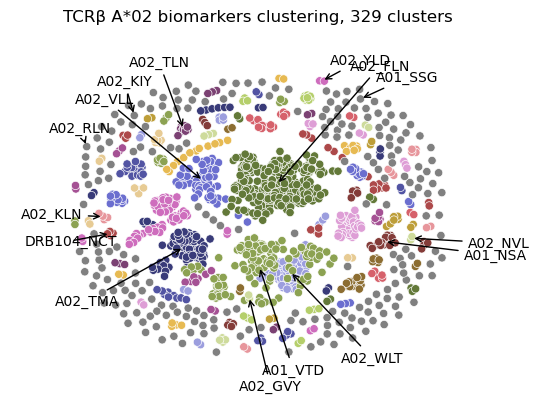

In [34]:
plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=950, global_zero_based=True)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.axis('off')
plt.legend().remove()
plt.title(f'TCRβ A*02 biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

In [35]:
res_alpha = seqs2hamming(aa_alpha_clones, viz_method='graphopt')
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()+1):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA', alpha=0.05)

TSAMHTMLF
KPLPEVKIL
YVDNSSLTI


Text(0.5, 1.0, 'TCRα A*02 biomarkers clustering, 93 clusters')

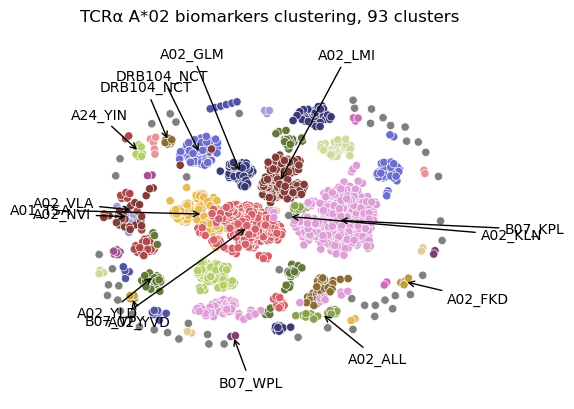

In [36]:
plot_clonotype_clustering_with_epitope_labeling(res_alpha, alpha_cluster_to_epi, vdjdb, gene='TRA', dist_to_center=950, global_zero_based=True)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.axis('off')
plt.legend().remove()
plt.title(f'TCRα A*02 biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')

In [37]:
all_clfs = {
     'random_beta': best_clfs_rb,
     'a02_beta': best_clfs_ab,
     'random_alpha': best_clfs_ra,
     'a02_alpha': best_clfs_aa,
}
X_test_data={
     'random_beta': X_test_rb,
     'a02_beta': X_test_ab,
     'random_alpha': X_test_ra,
     'a02_alpha': X_test_aa,
}
y_test_data={
     'random_beta': y_test_rb,
     'a02_beta': y_test_ab,
     'random_alpha': y_test_ra,
     'a02_alpha': y_test_aa,
}
X_train_data={
     'random_beta': X_train_rb,
     'a02_beta': X_train_ab,
     'random_alpha': X_train_ra,
     'a02_alpha': X_train_aa,
}
y_train_data={
     'random_beta': y_train_rb,
     'a02_beta': y_train_ab,
     'random_alpha': y_train_ra,
     'a02_alpha': y_train_aa,
}

In [38]:
model_df = []
f1_df = []
data_type_df = []
for data_type in ['random_beta','a02_beta', 'random_alpha', 'a02_alpha']:
    for model in ['svm', 'ab', 'knn', 'rfc', 'mlpclassifier', 'xgboost']:
        cur_score = f1_score(y_test_data[data_type], all_clfs[data_type][0][model].predict(X_test_data[data_type]))
        model_df.append(model)
        data_type_df.append(data_type)
        f1_df.append(cur_score)
comparison_df = pd.DataFrame({'model':model_df, 'f1': f1_df, 'data_type':data_type_df})

<AxesSubplot:xlabel='data_type', ylabel='f1'>

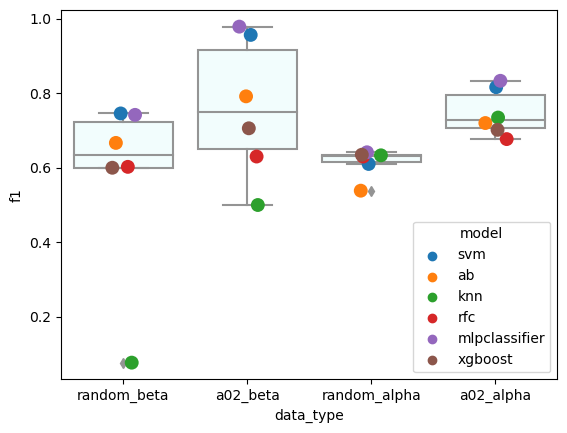

In [25]:
sns.stripplot(data=comparison_df, x="data_type", y="f1", hue="model", s=10)
sns.boxplot(data=comparison_df, x="data_type", y="f1", color='azure')

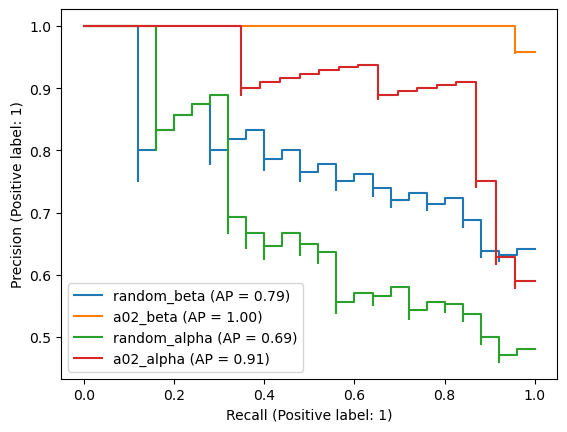

In [26]:
fig, ax = plt.subplots()
for key in all_clfs:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key][0]['svm'], X_test_data[key], y_test_data[key], name=key, ax=ax
    )

YLDAYNMMI
YINVFAFPF


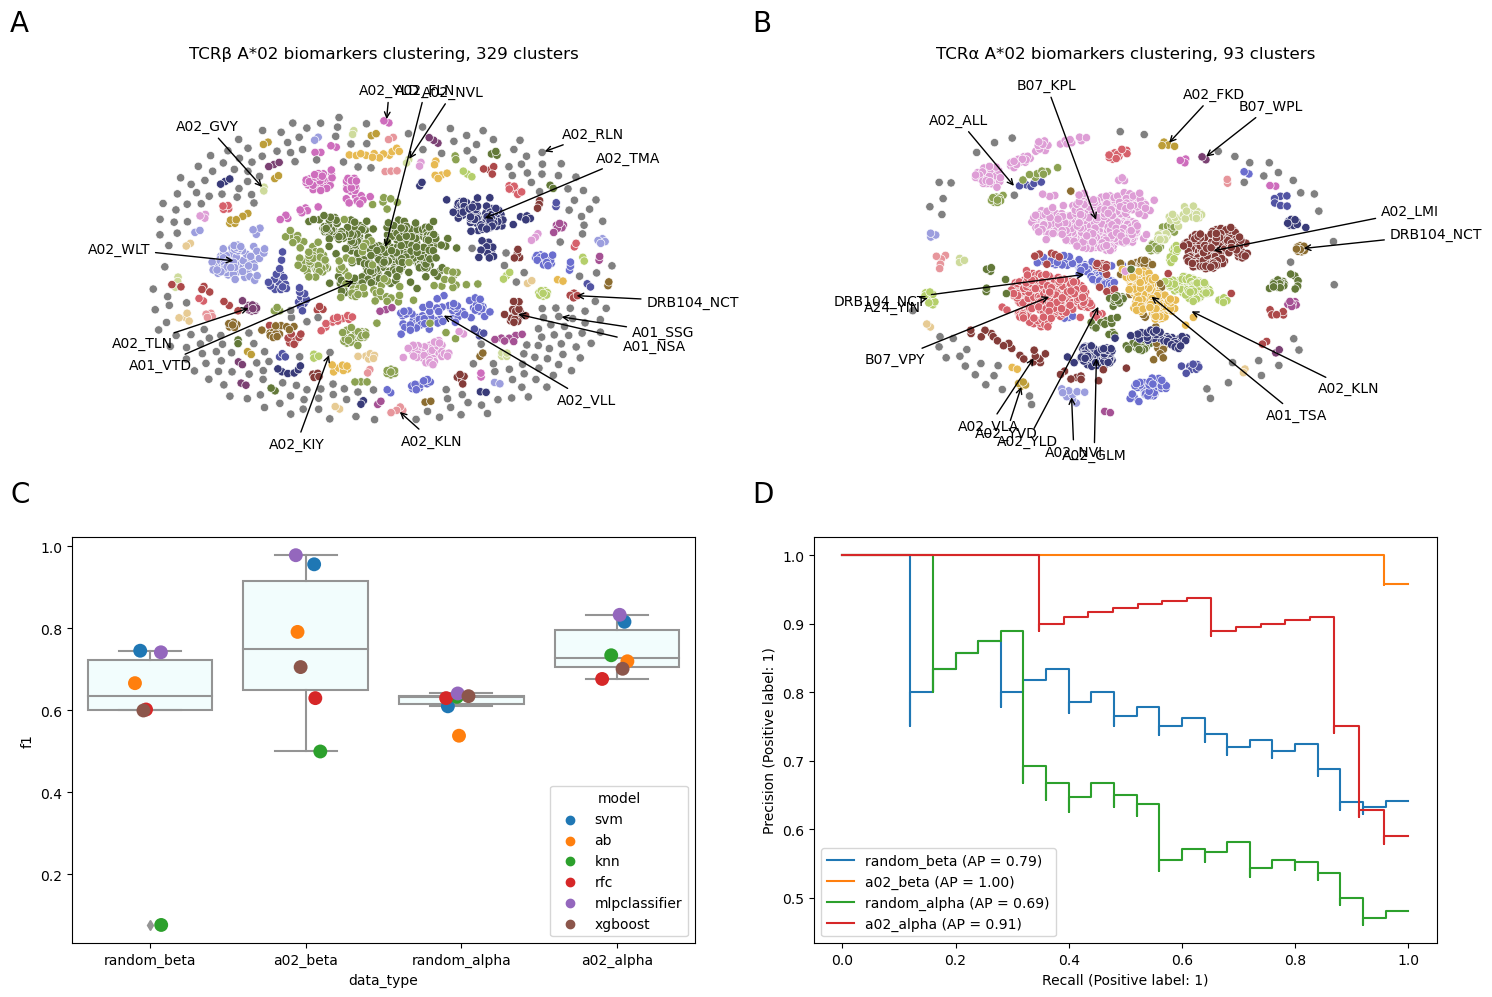

In [27]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(nrows=2, 
              ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.14


########################################################

ax0 = fig.add_subplot(gs[0, 0])
plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', 
                                                dist_to_center=950, global_zero_based=True, ax=ax0)
ax0.set_xlim(-1100, 1100)
ax0.set_ylim(-1100, 1100)
ax0.axis('off')
ax0.legend().remove()
ax0.set_title(f'TCRβ A*02 biomarkers clustering, {res_beta.cluster.max() + 1} clusters')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

########################################################
ax1 = fig.add_subplot(gs[0, 1])
plot_clonotype_clustering_with_epitope_labeling(res_alpha, alpha_cluster_to_epi, vdjdb, gene='TRA', 
                                                dist_to_center=950, global_zero_based=True, ax=ax1)
ax1.set_xlim(-1100, 1100)
ax1.set_ylim(-1100, 1100)
ax1.axis('off')
ax1.legend().remove()
ax1.set_title(f'TCRα A*02 biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

########################################################

ax2 = fig.add_subplot(gs[1, 0])

sns.stripplot(data=comparison_df, x="data_type", y="f1", hue="model", s=10, ax=ax2)
sns.boxplot(data=comparison_df, x="data_type", y="f1", color='azure', ax=ax2)
ax2.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

########################################################

ax3 = fig.add_subplot(gs[1, 1])
for key in all_clfs:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key][0]['svm'], X_test_data[key], y_test_data[key], name=key, ax=ax3
    )
ax3.text(delta_x, delta_y, 'D',
 horizontalalignment='left',
 verticalalignment='top',
transform=ax3.transAxes,
    size=font_size)

########################################################

plt.tight_layout()
plt.savefig("figures/fig6.svg")
plt.savefig("figures/fig6.pdf")
plt.savefig("figures/fig6.png")
plt.show()
